# Metode SVM

## Import Libraries

In [1]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from collections import Counter

import pandas as pd
import pandas.io.formats.html
import numpy as np
import matplotlib.pyplot as plt
import re
import string
import warnings
import nltk

warnings.filterwarnings("ignore", category=FutureWarning)

nltk.download("punkt")
nltk.download('punkt_tab') 
nltk.download("wordnet")
nltk.download('omw-1.4')
nltk.download("stopwords")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Dataset Config

In [2]:
DATASET_DIR = "smsa_doc-sentiment-prosa"

In [3]:
df_train = pd.read_csv(f"{DATASET_DIR}/train_preprocess.tsv", sep="\t", header=None)
df_valid = pd.read_csv(f"{DATASET_DIR}/valid_preprocess.tsv", sep="\t", header=None)
df_test_unmasked = pd.read_csv(f"{DATASET_DIR}/test_preprocess.tsv", sep="\t", header=None)
df_test_masked = pd.read_csv(f"{DATASET_DIR}/test_preprocess_masked_label.tsv", sep="\t", header=None)

with open(f"{DATASET_DIR}/vocab_uncased.txt", "r") as f:
    vocab = f.read().splitlines()

In [4]:
df_train.columns = ["text", "emotion"]
df_valid.columns = ["text", "emotion"]
df_test_unmasked.columns = ["text", "emotion"]
df_test_masked.columns = ["text", "emotion"]

df_train.sample(n=10, random_state=1)

,text,emotion
7030,"dapat rekomendasi makan di sini dari teman , k...",positive
2095,aduh pak tak usah kau marah-marah tak jelas be...,negative
7168,tempat nya walaupun kecil tapi cocok untuk mak...,positive
7969,paling juara desert di sini . beragam pilihan ...,positive
6320,zionis adalah bangsa paling sombong sekaligus ...,negative
6136,makanan di sini tidak pernah mengecewakan . se...,positive
4687,bangga banget punya pak jokowi sebagai preside...,positive
9934,wow ini indomie keju nya banyak amat sampai su...,positive
7868,saya biasanya menonton channel global tv,neutral
4865,walau aku suka pamer 2 jari tapi hati aku tida...,positive


In [5]:
df_valid.sample(n=10, random_state=1)

,text,emotion
1179,tidak amburadul,positive
255,"ini foton pakai handphone xiaomi note 4 , tamp...",negative
304,baru kali ini saya menikmati makanan sunda . s...,positive
403,bagi penggemar kopi susu mampirlah ke sini . a...,positive
75,kita makan di sini karena terjebak macet dan s...,positive
119,"bagus tempat , bagus makanan . pokok nya tidak...",positive
912,gue enggak mau jadi ikutan goblok seperti yang...,negative
1073,nikmati mi ayam atau mi chai shu yang enak di ...,positive
496,customer service indohome tidak pernah gagal d...,positive
1161,di valley kami sekeluarga sangat senang meliha...,positive


In [6]:
df_test_unmasked.sample(n=10, random_state=1)

,text,emotion
304,aku kecewa dengan pelayanan hotel yang semalam...,negative
340,artis cowok pop banci semua .,negative
47,aplikasi tipu . sialan . mengembalikan duit gu...,negative
67,udahlah kecewa jakarta dapet nya anies - sandi...,negative
479,kerja dari pagi sampai pagi lagi itu cuma baka...,neutral
485,tidur yang cukup tiap hari nya bisa bikin bada...,neutral
310,"tidak ada enak nya makan di sana , bakso tidak...",negative
31,"saya hilang 2.5 juta dari apa ini karena , ter...",negative
249,pengiriman barang menggunakan jne sangat memua...,positive
90,"menyesal tidak sih ganti handphone , dari ipho...",negative


In [7]:
df_test_masked.sample(n=10, random_state=1)

,text,emotion
304,aku kecewa dengan pelayanan hotel yang semalam...,neutral
340,artis cowok pop banci semua .,neutral
47,aplikasi tipu . sialan . mengembalikan duit gu...,neutral
67,udahlah kecewa jakarta dapet nya anies - sandi...,neutral
479,kerja dari pagi sampai pagi lagi itu cuma baka...,neutral
485,tidur yang cukup tiap hari nya bisa bikin bada...,neutral
310,"tidak ada enak nya makan di sana , bakso tidak...",neutral
31,"saya hilang 2.5 juta dari apa ini karena , ter...",neutral
249,pengiriman barang menggunakan jne sangat memua...,neutral
90,"menyesal tidak sih ganti handphone , dari ipho...",neutral


## Preprocessing

In [8]:
def to_lowercase(text):
    return text.lower()

def tokenize(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens]
    return ' '.join(tokens)

In [9]:
df_train['text'] = df_train['text'].apply(to_lowercase)
df_valid['text'] = df_valid['text'].apply(to_lowercase)
df_test_unmasked['text'] = df_test_unmasked['text'].apply(to_lowercase)
df_test_masked['text'] = df_test_masked['text'].apply(to_lowercase)

df_train['text'] = df_train['text'].apply(tokenize)
df_valid['text'] = df_valid['text'].apply(tokenize)
df_test_unmasked['text'] = df_test_unmasked['text'].apply(tokenize)

In [10]:
df_train.head(10)

,text,emotion
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative
5,"makanan beragam , harga makanan di food stall ...",positive
6,pakai kartu kredit bca tidak untung malah rugi...,negative
7,"tempat unik , bagus buat foto , makanan enak ,...",positive
8,saya bersama keluarga baru saja menikmati peng...,positive
9,bersyukur,positive


## Exploratory Data Analysis

C:\Users\User\AppData\Local\Temp/ipykernel_21356/3760294676.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels([f"{emotion} {emotion_emoticons[emotion]}" for emotion in emotion_counts.index], rotation=0)


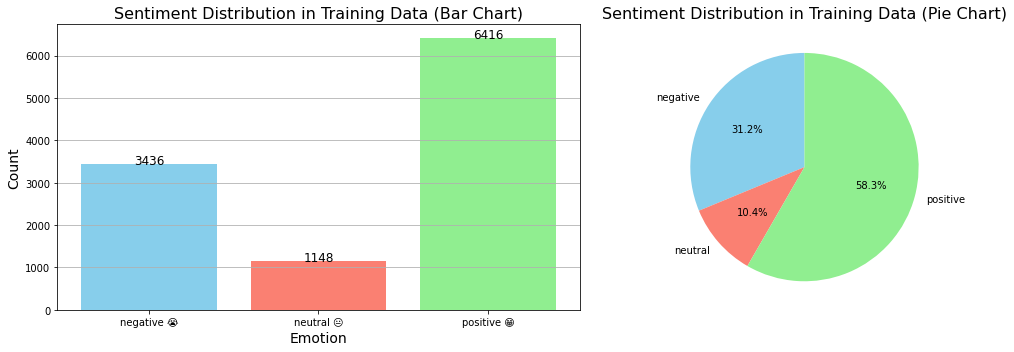

emotion
negative    3436
neutral     1148
positive    6416
Name: text, dtype: int64


In [11]:
emotion_emoticons = {
    'positive': '😁',
    'negative': '😭',
    'neutral': '😐'
}

emotion_counts = df_train.groupby('emotion').text.count()

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].bar(emotion_counts.index, emotion_counts, color=['skyblue', 'salmon', 'lightgreen'])
axs[0].set_title("Sentiment Distribution in Training Data (Bar Chart)", fontsize=16)
axs[0].set_xlabel("Emotion", fontsize=14)
axs[0].set_ylabel("Count", fontsize=14)
axs[0].set_xticklabels([f"{emotion} {emotion_emoticons[emotion]}" for emotion in emotion_counts.index], rotation=0)
axs[0].yaxis.grid(True)

for i, count in enumerate(emotion_counts):
    axs[0].text(i, count + 0.5, str(count), ha='center', fontsize=12)

emotion_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['skyblue', 'salmon', 'lightgreen'], ax=axs[1])
axs[1].set_title("Sentiment Distribution in Training Data (Pie Chart)", fontsize=16)
axs[1].set_ylabel('')

plt.tight_layout()
plt.show()

print(emotion_counts)

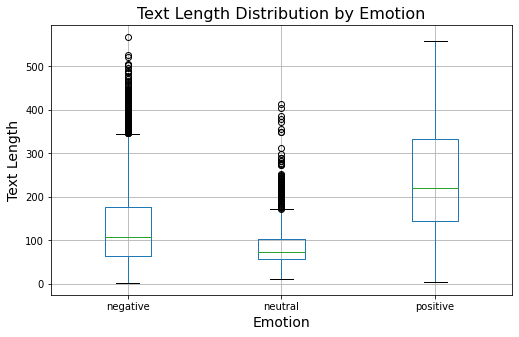

In [12]:
df_train['text_length'] = df_train['text'].apply(len)

fig, ax = plt.subplots(figsize=(8, 5))
df_train.boxplot(column='text_length', by='emotion', ax=ax)
ax.set_title("Text Length Distribution by Emotion", fontsize=16)
ax.set_xlabel("Emotion", fontsize=14)
ax.set_ylabel("Text Length", fontsize=14)
plt.suptitle('')
plt.show()


C:\Users\User\AppData\Local\Temp/ipykernel_21356/2102747433.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(words, rotation=45)
C:\Users\User\AppData\Local\Temp/ipykernel_21356/2102747433.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(words, rotation=45)
C:\Users\User\AppData\Local\Temp/ipykernel_21356/2102747433.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(words, rotation=45)


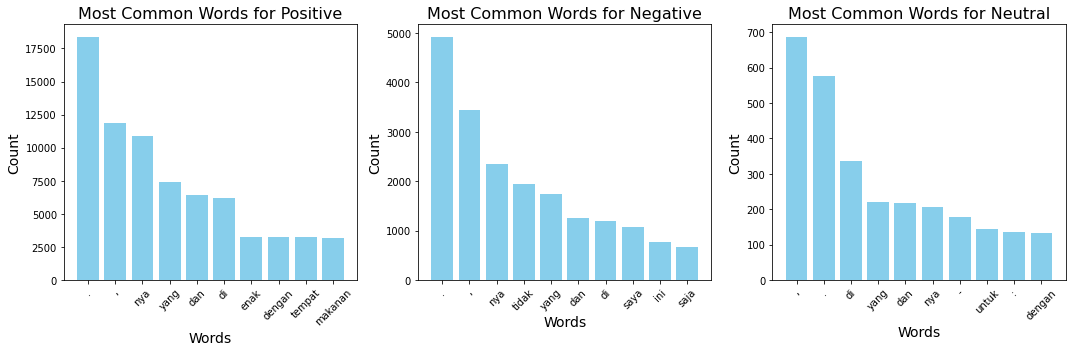

In [13]:
def common_words(emotion):
    words = ' '.join(df_train[df_train['emotion'] == emotion]['text']).split()
    words = [word for word in words if word.lower() not in stopwords.words('english')]
    return Counter(words).most_common(10)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for ax, emotion in zip(axs, emotion_emoticons.keys()):
    common = common_words(emotion)
    words, counts = zip(*common)
    ax.bar(words, counts, color=['skyblue'] * len(words))
    ax.set_title(f'Most Common Words for {emotion.capitalize()}', fontsize=16)
    ax.set_xlabel("Words", fontsize=14)
    ax.set_ylabel("Count", fontsize=14)
    ax.set_xticklabels(words, rotation=45)

plt.tight_layout()
plt.show()


## Traning Preparation

 ### Encode Emotion Column

In [14]:
emotion_encoding = {'negative': 0, 'neutral': 1, 'positive': 2}

df_train['emotion'] = df_train['emotion'].replace(emotion_encoding)
df_valid['emotion'] = df_valid['emotion'].replace(emotion_encoding)
df_test_unmasked['emotion'] = df_test_unmasked['emotion'].replace(emotion_encoding)
df_test_masked['emotion'] = df_test_masked['emotion'].replace(emotion_encoding)

### Train and Validation

In [15]:
cleaned_vocab = [string.strip() for string in vocab if string.strip()]
cleaned_vocab = list(dict.fromkeys(cleaned_vocab))
vectorizer = CountVectorizer(vocabulary=cleaned_vocab)

X_train = vectorizer.transform(df_train['text'])
y_train = df_train['emotion']
X_valid = vectorizer.transform(df_valid['text'])
y_valid = df_valid['emotion']
X_test = vectorizer.transform(df_test_unmasked['text'])
y_test = df_test_unmasked['emotion']

### Report and Visualizer

In [16]:
def class_report_validation(y_valid, y_valid_pred):
  accuracy = accuracy_score(y_valid, y_valid_pred)
  precision = precision_score(y_valid, y_valid_pred, average='macro')
  recall = recall_score(y_valid, y_valid_pred, average='macro')
  f1 = f1_score(y_valid, y_valid_pred, average='macro')

  print(f"Accuracy\t: {accuracy}")
  print(f'Precision\t: {precision}')
  print(f'Recall\t\t: {recall}')
  print(f'F1-Score\t: {f1}\n')

  print(classification_report(y_valid, y_valid_pred, target_names=['negative', 'neutral', 'positive']))

def class_report_test(y_test, y_test_pred):
  accuracy = accuracy_score(y_test, y_test_pred)
  precision = precision_score(y_test, y_test_pred, average='macro')
  recall = recall_score(y_test, y_test_pred, average='macro')
  f1 = f1_score(y_test, y_test_pred, average='macro')

  print(f'Test Accuracy\t: {accuracy}')
  print(f'Test Precision\t: {precision}')
  print(f'Test Recall\t: {recall}')
  print(f'Test F1-Score\t: {f1}\n')

  print(classification_report(y_test, y_test_pred, target_names=['negative', 'neutral', 'positive']))

def visualize_misclassifications(df_test_unmasked, y_test_pred, kernel):
    df_test_unmasked['predicted_emotion'] = y_test_pred
    misclassified = df_test_unmasked[df_test_unmasked['emotion'] != df_test_unmasked['predicted_emotion']]

    misclassified_count = misclassified[['text', 'emotion', 'predicted_emotion']].shape[0]
    total_count = df_test_unmasked.shape[0]
    misclassified_percentage = (misclassified_count / total_count) * 100

    print(f'Banyak data yang salah diprediksi: {misclassified_count} ({misclassified_percentage:.2f}%)')

    emotion_decoding = {0: 'negative', 1: 'neutral', 2: 'positive'}
    misclassified['emotion'] = misclassified['emotion'].replace(emotion_decoding)
    misclassified['predicted_emotion'] = misclassified['predicted_emotion'].replace(emotion_decoding)

    misclassified_counts = misclassified.groupby('emotion').size()

    emotion_emoticons = {
        'positive': '😁',
        'negative': '😭',
        'neutral': '😐'
    }

    fig, ax = plt.subplots(figsize=(8, 5))
    misclassified_counts.plot(kind='bar', color=['salmon', 'lightblue', 'lightgreen'], ax=ax)

    ax.set_title(f"Misclassification Distribution for {kernel} Kernel", fontsize=16)
    ax.set_xlabel('True Emotions', fontsize=14)
    ax.set_ylabel('Count of Misclassifications', fontsize=14)

    ax.set_xticklabels([f"{emotion} {emotion_emoticons[emotion]}" for emotion in misclassified_counts.index], rotation=0)

    for i, count in enumerate(misclassified_counts):
        ax.text(i, count + 0.5, str(count), ha='center', fontsize=12)

    ax.yaxis.grid(True)
    plt.tight_layout()
    plt.show()

    print("\nExamples of Misclassifications:")
    misclassified_samples = misclassified[['text', 'emotion', 'predicted_emotion']].sample(n=5, random_state=1)

    for index, row in misclassified_samples.iterrows():
        true_emotion_emoticon = emotion_emoticons[row['emotion']]
        predicted_emotion_emoticon = emotion_emoticons[row['predicted_emotion']]
        print(f"Text: {row['text']}")
        print(f"  True Emotion: {row['emotion']} {true_emotion_emoticon}")
        print(f"  Predicted Emotion: {row['predicted_emotion']} {predicted_emotion_emoticon}")
        print('-' * 80)


## Experiment 1 : Default Kernel (RBF Kernel)

In [17]:
svm_model = SVC()
svm_model.fit(X_train, y_train)

SVC()

### Validation

In [18]:
y_valid_pred = svm_model.predict(X_valid)

class_report_validation(y_valid, y_valid_pred)

Accuracy	: 0.8634920634920635
Precision	: 0.8312069551594691
Recall		: 0.8104938481508515
F1-Score	: 0.8187329586485871

              precision    recall  f1-score   support

    negative       0.78      0.86      0.82       394
     neutral       0.79      0.67      0.72       131
    positive       0.92      0.90      0.91       735

    accuracy                           0.86      1260
   macro avg       0.83      0.81      0.82      1260
weighted avg       0.87      0.86      0.86      1260



### Test

In [19]:
y_test_pred = svm_model.predict(X_test)

class_report_test(y_test, y_test_pred)

Test Accuracy	: 0.724
Test Precision	: 0.774054649054649
Test Recall	: 0.6628673613967732
Test F1-Score	: 0.676297862344374

              precision    recall  f1-score   support

    negative       0.64      0.98      0.77       204
     neutral       0.80      0.40      0.53        88
    positive       0.89      0.62      0.73       208

    accuracy                           0.72       500
   macro avg       0.77      0.66      0.68       500
weighted avg       0.77      0.72      0.71       500



### Misclassified

Banyak data yang salah diprediksi: 138 (27.60%)


C:\Users\User\AppData\Local\Temp/ipykernel_21356/1161697630.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclassified['emotion'] = misclassified['emotion'].replace(emotion_decoding)
C:\Users\User\AppData\Local\Temp/ipykernel_21356/1161697630.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclassified['predicted_emotion'] = misclassified['predicted_emotion'].replace(emotion_decoding)


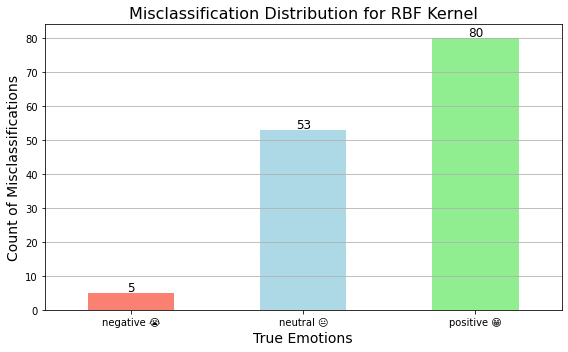


Examples of Misclassifications:
Text: kalau tidak suka gaperlu didukung mas , dukung saja yang menurut mas daus itu bisa bawa indonesia jauh lebih baik . yang penting kita harus menomorsatukan asas etika .
  True Emotion: neutral 😐
  Predicted Emotion: negative 😭
--------------------------------------------------------------------------------
Text: kami bukan dalam kapasitas menentukan jangan / nyapres , mbk .
  True Emotion: neutral 😐
  Predicted Emotion: negative 😭
--------------------------------------------------------------------------------
Text: salut banget sih sama pemimpin yang selalu bisa melihat poin plus yang ada di diri orang-orang di sekitar nya .
  True Emotion: positive 😁
  Predicted Emotion: negative 😭
--------------------------------------------------------------------------------
Text: saya dukung ahok itu tidak ada hubungan nya dengan etnis dia atau agama ahok . bahkan saya tak tahu agama dia apa . saya dukung ahok karena saya suka fenomena baru dalam pemerintahan

In [20]:
visualize_misclassifications(df_test_unmasked, y_test_pred, "RBF")

## Experiment 2 : Linear Kernel

In [21]:
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

SVC(kernel='linear')

### Validation

In [22]:
y_valid_pred = svm_model.predict(X_valid)

class_report_validation(y_valid, y_valid_pred)

Accuracy	: 0.8555555555555555
Precision	: 0.8194969304540591
Recall		: 0.8109257477031449
F1-Score	: 0.8134744000760055

              precision    recall  f1-score   support

    negative       0.77      0.87      0.82       394
     neutral       0.76      0.69      0.72       131
    positive       0.92      0.88      0.90       735

    accuracy                           0.86      1260
   macro avg       0.82      0.81      0.81      1260
weighted avg       0.86      0.86      0.86      1260



### Test

In [23]:
y_test_pred = svm_model.predict(X_test)

class_report_test(y_test, y_test_pred)

Test Accuracy	: 0.734
Test Precision	: 0.7218644161901061
Test Recall	: 0.6831750765574295
Test F1-Score	: 0.6937481441940382

              precision    recall  f1-score   support

    negative       0.69      0.85      0.76       204
     neutral       0.66      0.47      0.55        88
    positive       0.81      0.74      0.77       208

    accuracy                           0.73       500
   macro avg       0.72      0.68      0.69       500
weighted avg       0.74      0.73      0.73       500



### Misclassified

Banyak data yang salah diprediksi: 133 (26.60%)


C:\Users\User\AppData\Local\Temp/ipykernel_21356/1161697630.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclassified['emotion'] = misclassified['emotion'].replace(emotion_decoding)
C:\Users\User\AppData\Local\Temp/ipykernel_21356/1161697630.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclassified['predicted_emotion'] = misclassified['predicted_emotion'].replace(emotion_decoding)


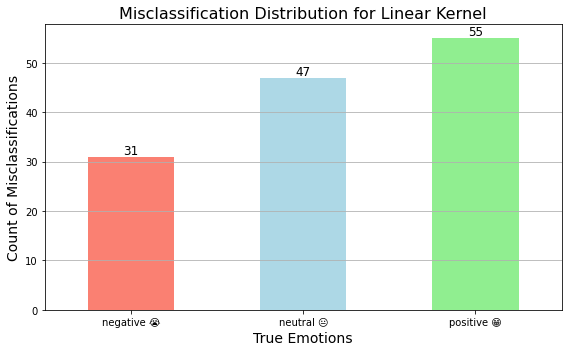


Examples of Misclassifications:
Text: kesian sheila on 7 tenggelem sekarang .
  True Emotion: negative 😭
  Predicted Emotion: positive 😁
--------------------------------------------------------------------------------
Text: oppo f7 menurut gue mantap banget sih . mulai dari kamera depan nya yang bersih . terus layar nya penuh display pakai gorilla glass 5 . lalu kamera belakang nya naik tingkat banget dari yang sebelumnya . tidak menyesal gue beli ini hp .
  True Emotion: positive 😁
  Predicted Emotion: negative 😭
--------------------------------------------------------------------------------
Text: adab di media sosial itu jelas , kok . suka silakan like , mengikuti . tidak suka , unfoll / block , simpel . dan kita memiliki hak yang sama untuk melakukan nya .
  True Emotion: neutral 😐
  Predicted Emotion: negative 😭
--------------------------------------------------------------------------------
Text: sudah hampir 3 bulan ini , pengembalian dana dana tidak balik , 2 kali dapat notifi

In [24]:
visualize_misclassifications(df_test_unmasked, y_test_pred, "Linear")

## Experiment 3 : Poly Kernel

In [25]:
svm_model = SVC(kernel='poly')
svm_model.fit(X_train, y_train)

SVC(kernel='poly')

### Validation

In [26]:
y_valid_pred = svm_model.predict(X_valid)

class_report_validation(y_valid, y_valid_pred)

Accuracy	: 0.6880952380952381
Precision	: 0.8135025082058588
Recall		: 0.5377690420790576
F1-Score	: 0.4855365020437814

              precision    recall  f1-score   support

    negative       0.50      0.92      0.65       394
     neutral       1.00      0.01      0.02       131
    positive       0.94      0.68      0.79       735

    accuracy                           0.69      1260
   macro avg       0.81      0.54      0.49      1260
weighted avg       0.81      0.69      0.67      1260



### Test

In [27]:
y_test_pred = svm_model.predict(X_test)

class_report_test(y_test, y_test_pred)

Test Accuracy	: 0.446
Test Precision	: 0.40591063279400635
Test Recall	: 0.3636563599798894
Test F1-Score	: 0.26222847319893733

              precision    recall  f1-score   support

    negative       0.42      0.98      0.59       204
     neutral       0.00      0.00      0.00        88
    positive       0.79      0.11      0.19       208

    accuracy                           0.45       500
   macro avg       0.41      0.36      0.26       500
weighted avg       0.50      0.45      0.32       500



C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

### Misclassified

C:\Users\User\AppData\Local\Temp/ipykernel_21356/1161697630.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclassified['emotion'] = misclassified['emotion'].replace(emotion_decoding)
C:\Users\User\AppData\Local\Temp/ipykernel_21356/1161697630.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclassified['predicted_emotion'] = misclassified['predicted_emotion'].replace(emotion_decoding)


Banyak data yang salah diprediksi: 277 (55.40%)


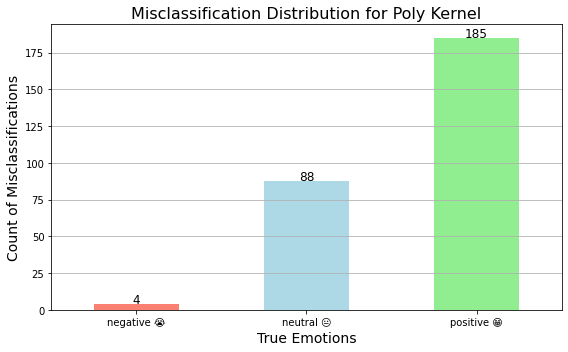


Examples of Misclassifications:
Text: bondan winarno yang suka bilang maknyus sekarang sudah tiada .
  True Emotion: neutral 😐
  Predicted Emotion: negative 😭
--------------------------------------------------------------------------------
Text: wuih , ada yang baru di aplikasi nih . sekarang bisa pesan tiket bus ? mantap !
  True Emotion: positive 😁
  Predicted Emotion: negative 😭
--------------------------------------------------------------------------------
Text: hari ini iseng mencoba versi beta nya , mantap search engine nya . tidak pusing lagi kalau mau cari tiket murah dan waktu penerbangan : memudahkan aku .
  True Emotion: positive 😁
  Predicted Emotion: negative 😭
--------------------------------------------------------------------------------
Text: perempuan yang malang itu sekarang sudah tutup usia .
  True Emotion: neutral 😐
  Predicted Emotion: negative 😭
--------------------------------------------------------------------------------
Text: saya suka beli tiket di tiket

In [28]:
visualize_misclassifications(df_test_unmasked, y_test_pred, "Poly")

## Experiment 4 : Sigmoid Kernel

In [29]:
svm_model = SVC(kernel='sigmoid')
svm_model.fit(X_train, y_train)

SVC(kernel='sigmoid')

### Validation

In [30]:
y_valid_pred = svm_model.predict(X_valid)

class_report_validation(y_valid, y_valid_pred)

Accuracy	: 0.7428571428571429
Precision	: 0.7160203083100279
Recall		: 0.6799712008387395
F1-Score	: 0.6951439712421945

              precision    recall  f1-score   support

    negative       0.64      0.66      0.65       394
     neutral       0.70      0.56      0.62       131
    positive       0.80      0.82      0.81       735

    accuracy                           0.74      1260
   macro avg       0.72      0.68      0.70      1260
weighted avg       0.74      0.74      0.74      1260



### Test

In [31]:
y_test_pred = svm_model.predict(X_test)

class_report_test(y_test, y_test_pred)

Test Accuracy	: 0.514
Test Precision	: 0.5474523007856341
Test Recall	: 0.4534399424105306
Test F1-Score	: 0.4573544721823401

              precision    recall  f1-score   support

    negative       0.51      0.69      0.59       204
     neutral       0.63      0.19      0.30        88
    positive       0.50      0.48      0.49       208

    accuracy                           0.51       500
   macro avg       0.55      0.45      0.46       500
weighted avg       0.53      0.51      0.50       500



### Misclassified

Banyak data yang salah diprediksi: 243 (48.60%)


C:\Users\User\AppData\Local\Temp/ipykernel_21356/1161697630.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclassified['emotion'] = misclassified['emotion'].replace(emotion_decoding)
C:\Users\User\AppData\Local\Temp/ipykernel_21356/1161697630.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclassified['predicted_emotion'] = misclassified['predicted_emotion'].replace(emotion_decoding)


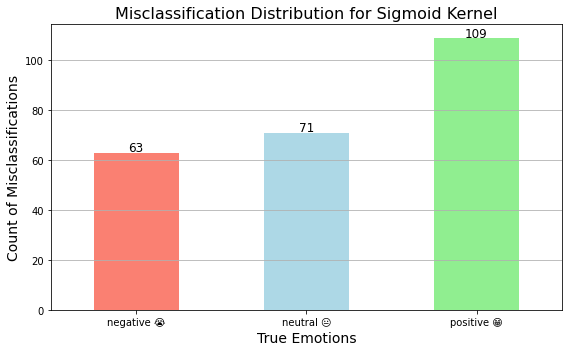


Examples of Misclassifications:
Text: di jember itu ada tempat makan enak . nama nya warung bakaran mbak vivi . makanan nya enak-enak . bakaran nya itu pas banget matang nya . dan yang paling penting nya harga nya murah sekali untuk makanan seenak itu .
  True Emotion: positive 😁
  Predicted Emotion: negative 😭
--------------------------------------------------------------------------------
Text: bondan winarno yang suka bilang maknyus sekarang sudah tiada .
  True Emotion: neutral 😐
  Predicted Emotion: negative 😭
--------------------------------------------------------------------------------
Text: gojek fitur nya makin banyak .
  True Emotion: neutral 😐
  Predicted Emotion: positive 😁
--------------------------------------------------------------------------------
Text: keberadaan peraturan presiden nomor 54 tahun 2018 tentang strategi nasional pencegahan korupsi yang telah diteken oleh presiden joko widodo pada 20 juli 2018 silam diharapkan mampu menghasilkan perubahan mendasar , 

In [32]:
visualize_misclassifications(df_test_unmasked, y_test_pred, "Sigmoid")

## Experiment 5 : Hyperparameter Tuning

In [33]:
def evaluate_and_visualize_grid_search(X_train, y_train, X_valid, y_valid):
    parameters = {'kernel': ['linear', 'rbf'], 'C': [0.1, 1, 10]}

    grid_search = GridSearchCV(SVC(), parameters, scoring='f1_macro', refit=True)
    grid_search.fit(X_train, y_train)

    results_df = pd.DataFrame(grid_search.cv_results_)

    sorted_results = results_df.sort_values(by='mean_test_score', ascending=False)
    print("Top Grid Search Results:")
    print(sorted_results[['param_kernel', 'param_C', 'mean_test_score', 'std_test_score', 'rank_test_score']].head())

    fig, ax = plt.subplots(figsize=(10, 6))

    pivot_table = results_df.pivot_table(index='param_C', columns='param_kernel', values='mean_test_score')
    pivot_table.plot(kind='bar', ax=ax)
    
    ax.set_title('Comparison of SVM Kernels and C values based on F1-Score', fontsize=16)
    ax.set_xlabel('C Values', fontsize=14)
    ax.set_ylabel('Mean F1-Score', fontsize=14)
    ax.legend(title="Kernel", fontsize=12)

    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

    best_model = grid_search.best_estimator_
    best_score = grid_search.best_score_
    print(f"\nBest model: {best_model}")
    print(f"Best cross-validation score (F1-macro): {best_score:.4f}")

    y_valid_pred = best_model.predict(X_valid)

    print("\nEvaluation on validation set complete.")

Top Grid Search Results:
  param_kernel param_C  mean_test_score  std_test_score  rank_test_score
0       linear     0.1         0.833951        0.006440                1
5          rbf      10         0.829564        0.003347                2
3          rbf       1         0.819347        0.007095                3
2       linear       1         0.792678        0.008604                4
4       linear      10         0.760392        0.007070                5


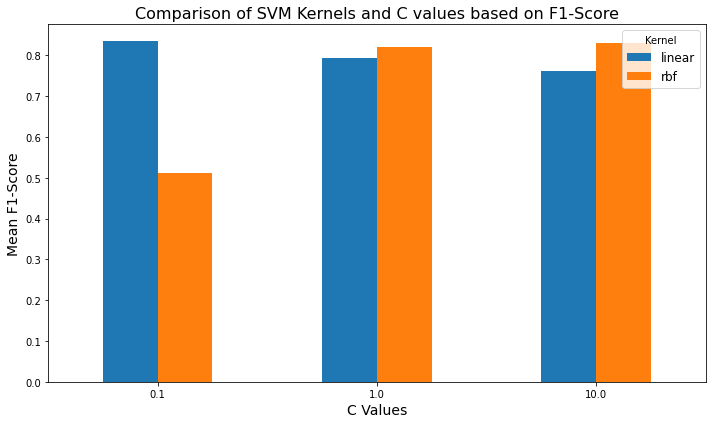


Best model: SVC(C=0.1, kernel='linear')
Best cross-validation score (F1-macro): 0.8340

Evaluation on validation set complete.


In [34]:
evaluate_and_visualize_grid_search(X_train, y_train, X_valid, y_valid)

In [35]:
svm_model = SVC(kernel='linear', C=0.1)
svm_model.fit(X_train, y_train)

SVC(C=0.1, kernel='linear')

### Validation

In [36]:
y_valid_pred = svm_model.predict(X_valid)

class_report_validation(y_valid, y_valid_pred)

Accuracy	: 0.873015873015873
Precision	: 0.8398327601335632
Recall		: 0.8453457977396664
F1-Score	: 0.8412648971209663

              precision    recall  f1-score   support

    negative       0.79      0.89      0.84       394
     neutral       0.79      0.76      0.78       131
    positive       0.94      0.88      0.91       735

    accuracy                           0.87      1260
   macro avg       0.84      0.85      0.84      1260
weighted avg       0.88      0.87      0.87      1260



### Test

In [37]:
y_test_pred = svm_model.predict(X_test)

class_report_test(y_test, y_test_pred)

Test Accuracy	: 0.766
Test Precision	: 0.7862635194246431
Test Recall	: 0.7073535125005713
Test F1-Score	: 0.7218391311457638

              precision    recall  f1-score   support

    negative       0.69      0.96      0.80       204
     neutral       0.77      0.45      0.57        88
    positive       0.90      0.71      0.79       208

    accuracy                           0.77       500
   macro avg       0.79      0.71      0.72       500
weighted avg       0.79      0.77      0.76       500



### Misclassified

Banyak data yang salah diprediksi: 117 (23.40%)


C:\Users\User\AppData\Local\Temp/ipykernel_21356/1161697630.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclassified['emotion'] = misclassified['emotion'].replace(emotion_decoding)
C:\Users\User\AppData\Local\Temp/ipykernel_21356/1161697630.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclassified['predicted_emotion'] = misclassified['predicted_emotion'].replace(emotion_decoding)


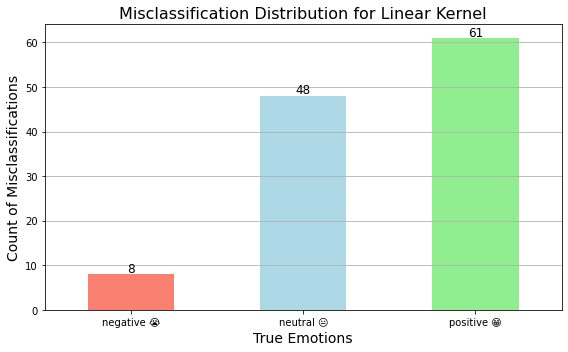


Examples of Misclassifications:
Text: banyak ya yang bisa dibanggakan dari seorang habibie , cerdas iya , rendah hati pula .
  True Emotion: positive 😁
  Predicted Emotion: negative 😭
--------------------------------------------------------------------------------
Text: selamat siang . jika selama 6 bulan tidak terdapat saldo rp . 0 tidak ada transaksi , maka sudah otomatis closed . namun untuk pengecekan status rekening anda dapat menghubungi bni call 1500046 .
  True Emotion: neutral 😐
  Predicted Emotion: negative 😭
--------------------------------------------------------------------------------
Text: gue bersyukur jokowi bakal jadi presiden selama sepuluh tahun .
  True Emotion: positive 😁
  Predicted Emotion: neutral 😐
--------------------------------------------------------------------------------
Text: salah satu kegemaran anak remaja indonesia sekarang adalah mendengar kpop .
  True Emotion: neutral 😐
  Predicted Emotion: negative 😭
--------------------------------------------

In [38]:
visualize_misclassifications(df_test_unmasked, y_test_pred, "Linear")